In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

138.430997671 60.8595704834 (112, 92)


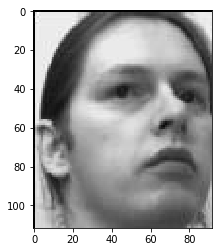

In [2]:
im = Image.open("image/umist_cropped.jpg")
data_orig = np.array(im)

ws = (112,92)
data = data_orig[ws[0]:2*ws[0],ws[1]:ws[1]*2]
print(np.mean(data), np.std(data), data.shape)
plt.imshow(data, cmap='gray')
plt.show()

In [3]:
def gibbs(X, W, I, K, gamma_shape, gamma_scale, max_iter):
    A_t = np.ones((W,I))*gamma_shape
    B_t = np.ones((W,I))*gamma_scale
    A_v = np.ones((I,K))*gamma_shape
    B_v = np.ones((I,K))*gamma_scale
    
    T = np.random.gamma(A_t,B_t)
    V = np.random.gamma(A_v,B_v)

    for n in range(max_iter):

        p = np.zeros((W, I ,K))
        S = np.zeros((W, I ,K))

        p = np.einsum("ik,kj->ikj", T, V)
        p = p/np.sum(p, axis = 1, keepdims = True)

        for v in range(W):
            for t in range(K):
                S[v, :, t] = np.random.binomial(X[v,t], p[v, :, t].squeeze())


        alpha_t = A_t + np.sum(S, axis=2)
        beta_t = 1./(B_t + np.einsum("i,kj,j->ik",np.ones(W),V,np.ones(K)))
        T = np.random.gamma(alpha_t, beta_t)
        
        alpha_v = A_v + np.sum(S, axis=0)
        beta_v = 1./(B_v + np.einsum("i,ik,j->kj", np.ones(W), T, np.ones(K)))
        V = np.random.gamma(alpha_v, beta_v)

        if n % 50 == 0:
            mean_diff = np.mean(np.abs(X - np.dot(T,V)))
            print("epoch %d: loss: "%n, mean_diff)
    return T, V

In [4]:
#Initialization
X = data
W = X.shape[0]
K = X.shape[1]
I = 20

data_variance = (np.std(X)/I)**2
data_mean = np.mean(X)/I/2.5

gamma_scale = data_variance/data_mean
gamma_shape = data_mean/gamma_scale

T, V = gibbs(X, W, I, K, gamma_shape, gamma_scale, 400)

epoch 0: loss:  42.6618889971
epoch 50: loss:  12.1566980161
epoch 100: loss:  8.71639895968
epoch 150: loss:  8.14145042858
epoch 200: loss:  7.68962052737
epoch 250: loss:  7.58172616655
epoch 300: loss:  7.63496082248
epoch 350: loss:  7.59147185513


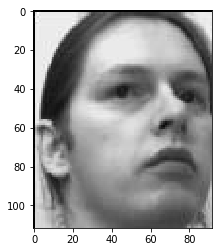

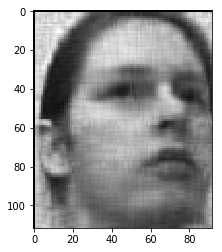

138.430997671 60.8595704834
136.875409746 59.4124994439


In [5]:
plt.imshow(X, cmap='gray')
plt.show()
plt.imshow(np.dot(T,V), cmap='gray')
plt.show()
print(np.mean(X), np.std(X))
print(np.mean(np.dot(T,V)), np.std(np.dot(T,V)))

In [6]:
def gibbs_mask(X, mask, W, I, K, gamma_shape, gamma_scale, max_iter):
    X = X * mask
    A_t = np.ones((W,I))*gamma_shape
    B_t = np.ones((W,I))*gamma_scale
    A_v = np.ones((I,K))*gamma_shape
    B_v = np.ones((I,K))*gamma_scale
    
    T = np.random.gamma(A_t,B_t)
    V = np.random.gamma(A_v,B_v)

    for n in range(max_iter):

        p = np.zeros((W, I ,K))
        S = np.zeros((W, I ,K))

        p = np.einsum("ik,kj->ikj", T, V)
        p = p/np.sum(p, axis = 1, keepdims = True)

        for v in range(W):
            for t in range(K):
                S[v, :, t] = np.random.binomial(X[v,t], p[v, :, t].squeeze())


        alpha_t = A_t + np.sum(S, axis=2)
        beta_t = 1./(B_t + np.einsum("ij, kj->ik", mask, V))
        T = np.random.gamma(alpha_t, beta_t)
        
        alpha_v = A_v + np.sum(S, axis=0)
        beta_v = 1./(B_v + np.einsum("ij, ik->kj", mask, T))
        V = np.random.gamma(alpha_v, beta_v)

        if n % 50 == 0:
            mean_diff = np.mean(np.abs(X - np.dot(T,V)))
            print("epoch %d: loss: "%n, mean_diff)
    return T, V

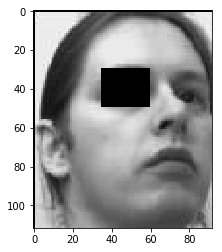

epoch 0: loss:  46.7938271379
epoch 50: loss:  18.7681975271
epoch 100: loss:  15.4683256197
epoch 150: loss:  14.1489508581
epoch 200: loss:  13.0878054745
epoch 250: loss:  12.1193138402
epoch 300: loss:  11.6218709721
epoch 350: loss:  11.2525348863


In [10]:
#Initialization
X = data
W = X.shape[0]
K = X.shape[1]
I = 20

data_variance = (np.std(X)/I)**2
data_mean = np.mean(X)/I/2.5

gamma_scale = data_variance/data_mean
gamma_shape = data_mean/gamma_scale

mask = np.ones((W,K)).astype(np.uint8)
mask[30:50,35:60] = 0
plt.imshow(X*mask, cmap='gray')
plt.show()

T_, V_ = gibbs_mask(X, mask, W, I, K, gamma_shape, gamma_scale, 400)

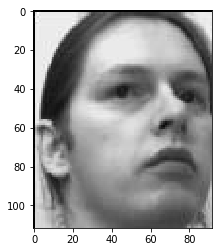

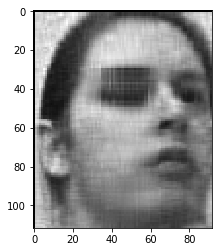

138.430997671 60.8595704834
135.545971865 59.9858557976


In [11]:
plt.imshow(X, cmap='gray')
plt.show()
plt.imshow(np.dot(T_,V_), cmap='gray')
plt.show()
print(np.mean(X), np.std(X))
print(np.mean(np.dot(T_,V_)), np.std(np.dot(T_,V_)))